In [104]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve 

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
import pipeline_tree as pipeline_tree

In [164]:
FEATURES = ['province','age','education', 'if_urban',
                 'wealth_index', 'if_own_house',
                 'if_employment', 'if_employment_current','employment_pay_method', 'if_earn_more',
                 'partner_edu', 
                 'num_child','sex_head_household', 'sexual_activity', 'ideal_num_child', 'partner_ideal_child', 'money_decide_person']
NUMERIC_FEATURES = ['age','education','if_own_house','if_employment_current','partner_edu','num_child','ideal_num_child']
CATGORICAL_FEATURES = ['province', 'if_urban',
                 'wealth_index',
                 'if_employment','employment_pay_method','if_earn_more', 
                 'sex_head_household', 'sexual_activity', 'partner_ideal_child', 'money_decide_person']
TARGET_LST = ['if_emo_vio', 'if_phy_vio', 'if_sex_vio', 'if_vio']

In [48]:
FILES = ['cleaned_data/cambodia_2014_cleaned.csv', 
         'cleaned_data/Maldives_2016_cleaned.csv', 
         'cleaned_data/Nepal_2016_cleaned.csv',
         'cleaned_data/Pakistan_2017_cleaned.csv',
         'cleaned_data/Philippines_2017_cleaned.csv']

# Pipeline

In [49]:
def split_data(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.20, 
                                                    random_state=505)
    return X_train, X_test, y_train, y_test

In [89]:
def preprocess_data(df, features_col, target_col, categorical_col):
    df.dropna(subset=[target_col],inplace=True)
    df = impute_missing_median(df, NUMERIC_FEATURES)
    df = fill_categorical_na_vals(df)
    features = df[features_col]
    features = pd.get_dummies(features, columns=categorical_col)
    target = df[target_col]
    return features, target

In [97]:
def impute_missing_median(df, col_lst):
    '''
    Impute missing values of continuous variables using the median value
    '''
    for col in col_lst:
        df.loc[(df[col] == "don't know") | (df[col] == "non-numeric response") , col] = None
        median = df[col].median()
        df[col].fillna(median,inplace=True)
    return df

In [99]:
def fill_categorical_na_vals(df):
    '''
    Find colums and rows with missing values. Print rows, returns list of
    columns.
    '''
    df = df.fillna(0)
    return df

In [139]:
def train_decision_tree(X_train, X_test, y_train, y_test):
    params = {'criterion': ['gini', 'entropy'],
                'max_depth': [3,5,10,15],
                'min_samples_split': [2,5,10]}
    grid_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=505), 
                              param_grid=params, 
                              cv=10,
                              return_train_score=True,
                              scoring=['f1', 'accuracy','precision','recall','roc_auc'],
                              refit='f1')

    grid_model.fit(X_train, y_train)

    grid_result = pd.DataFrame(grid_model.cv_results_)
    grid_result = grid_result[['params','mean_train_f1','mean_train_accuracy', 'mean_train_precision','mean_train_recall','mean_train_roc_auc']]
    grid_result = grid_result.sort_values(by=['mean_train_f1'], ascending=False)
#     pd.set_option('max_colwidth',500)
    return grid_result
#     print('Best model params: ', grid_result.loc[grid_result['mean_train_accuracy'] == max(grid_result['mean_train_accuracy'])]['params'])

In [169]:
def train_random_forest(X_train, X_test, y_train, y_test):
    params = {'n_estimators':[10, 100, 1000],
              'criterion': ['gini', 'entropy'],
              'max_depth': [3,5,10,15],
              'min_samples_split': [2,5,10]}
    grid_model = GridSearchCV(estimator=RandomForestClassifier(random_state=505), 
                              param_grid=params, 
                              cv=10,
                              return_train_score=True,
                              scoring=['f1', 'accuracy','precision','recall','roc_auc'],
                              refit='f1')

    grid_model.fit(X_train, y_train)

    grid_result = pd.DataFrame(grid_model.cv_results_)
    grid_result[['params','mean_train_f1','mean_train_accuracy', 'mean_train_precision','mean_train_recall','mean_train_roc_auc']]
    grid_result.sort_values(by=['mean_train_f1'], ascending=False)
    pd.set_option('max_colwidth',500)

In [148]:
def evaluate_test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    plot_precision_recall_curve(model, X_test, y_test)
    results_dict = {}
    results_dict['f1'] = metrics.f1_score(y_test, y_pred)
    results_dict['accuracy'] = metrics.accuracy_score(y_test, y_pred)
    results_dict['precision'] = metrics.precision_score(y_test, y_pred)
    results_dict['recall'] = metrics.recall_score(y_test, y_pred)
    results_dict['roc_auc'] = metrics.roc_auc_score(y_test, y_pred)
    plot_precision_recall_curve(model,X_test,y_test)    
    return results_dict

In [172]:
def plot_importances(model, X_train, n=10, title=''):
    '''
    Compute the relative importance of selected features in
    the model
    
    Inputs:
    - model
    - n (int): top n features, opt
    - title (str)
    '''
    plt.close()
    importances = model.feature_importances_
    np_features = np.array(X_train.columns)
    sorted_idx = np.argsort(importances)[len(np_features)-n:]
    padding = np.arange(len(sorted_idx)) + 0.5
    pl.barh(padding, importances[sorted_idx], align='center')
    pl.yticks(padding, np_features[sorted_idx])
    pl.xlabel("Relative Importance")
    pl.title(title)
    pl.show()

In [55]:
def read_data(csv):
    return pd.read_csv(csv)

# Cambodia

In [57]:
df = read_data('cleaned_data/cambodia_2014_cleaned.csv')

Exploratory Analysis

In [140]:
target_col = 'if_emo_vio'
features, target = preprocess_data(df, FEATURES, target_col, CATGORICAL_FEATURES)
X_train, X_test, y_train, y_test = split_data(features, target)
grid_result= train_decision_tree(X_train, X_test, y_train, y_test)

In [141]:
pd.set_option('max_colwidth',500)
grid_result

,params,mean_train_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_roc_auc
9,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}",0.813999,0.930782,0.959120,0.708654,0.964326
21,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}",0.757483,0.911818,0.926276,0.642156,0.952106
10,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}",0.747899,0.908456,0.912394,0.635921,0.950179
22,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}",0.714741,0.898586,0.901787,0.592914,0.942430
11,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10}",0.662410,0.879019,0.824708,0.554953,0.922366
23,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10}",0.646331,0.874493,0.817366,0.536064,0.919676
6,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}",0.591227,0.868373,0.889001,0.444635,0.863859
7,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}",0.565868,0.861650,0.868050,0.421128,0.855369
18,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}",0.518991,0.849280,0.824779,0.380349,0.851605
8,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}",0.515837,0.846479,0.799097,0.382351,0.836129


In [174]:
def one_country_model_decision_tree(df, TARGET_LST, FEATURES, CATGORICAL_FEATURES):
    '''
    Use decision tree to model data of one country
    '''
    for target_col in TARGET_LST:
        print("\n \n Target: ", target_col, "\n\n")
        features, target = preprocess_data(df, FEATURES, target_col, CATGORICAL_FEATURES)
        X_train, X_test, y_train, y_test = split_data(features, target)
        grid_result= train_decision_tree(X_train, X_test, y_train, y_test)
        for params in grid_result['params'][:3]:
            print('Params: ', params)
            good_model = DecisionTreeClassifier(**params).fit(X_train, y_train)
            result_dict = evaluate_test(good_model, X_test, y_test)
            print(result_dict)
            plot_importances(good_model, X_train, n=10, title= target_col + str(params))


 
 Target:  if_emo_vio 


Params:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.2833333333333333, 'accuracy': 0.7333333333333333, 'precision': 0.34, 'recall': 0.24285714285714285, 'roc_auc': 0.556082036775106}


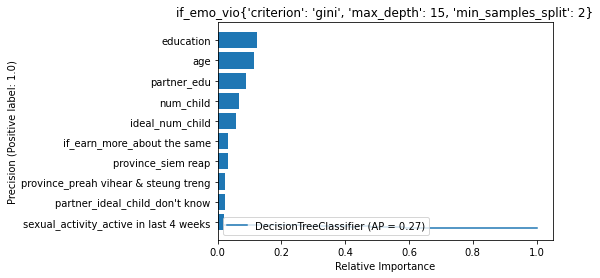

Params:  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.31896551724137934, 'accuracy': 0.7550387596899225, 'precision': 0.40217391304347827, 'recall': 0.2642857142857143, 'roc_auc': 0.5776874115983027}


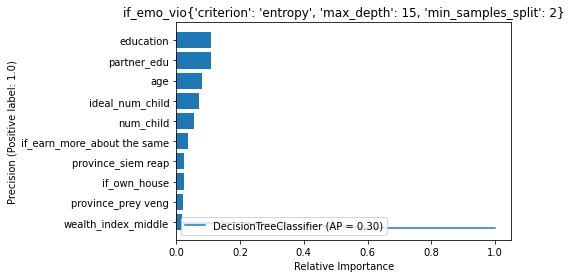

Params:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}
{'f1': 0.27555555555555555, 'accuracy': 0.7472868217054264, 'precision': 0.36470588235294116, 'recall': 0.22142857142857142, 'roc_auc': 0.5572489391796323}


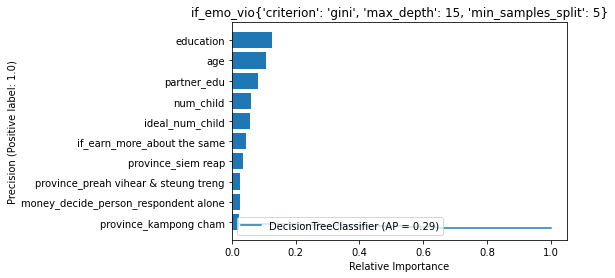


 
 Target:  if_phy_vio 


Params:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.16574585635359118, 'accuracy': 0.765891472868217, 'precision': 0.1595744680851064, 'recall': 0.1724137931034483, 'roc_auc': 0.5154183660857744}


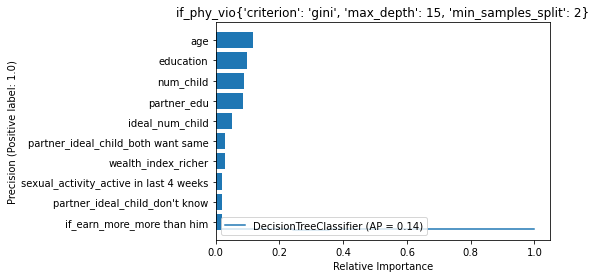

Params:  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.20382165605095545, 'accuracy': 0.8062015503875969, 'precision': 0.22857142857142856, 'recall': 0.1839080459770115, 'roc_auc': 0.5435669262143121}


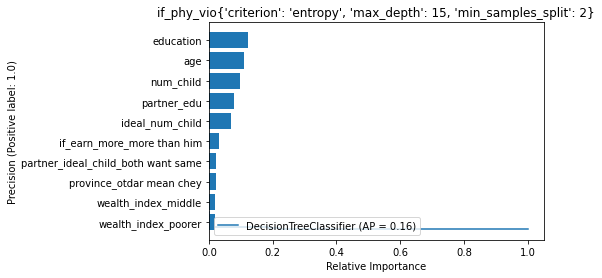

Params:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}
{'f1': 0.24390243902439024, 'accuracy': 0.8077519379844961, 'precision': 0.2597402597402597, 'recall': 0.22988505747126436, 'roc_auc': 0.5638672599184278}


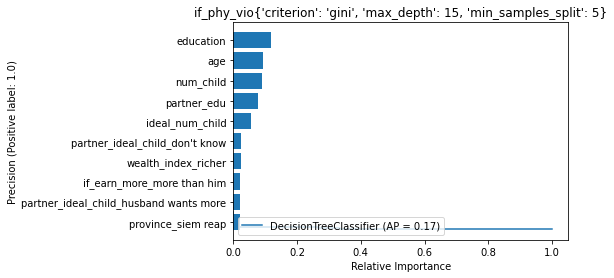


 
 Target:  if_sex_vio 


Params:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.15686274509803924, 'accuracy': 0.9333333333333333, 'precision': 0.14814814814814814, 'recall': 0.16666666666666666, 'roc_auc': 0.5648148148148149}


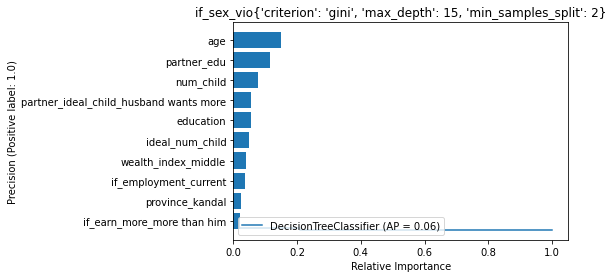

Params:  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.11320754716981132, 'accuracy': 0.9271317829457364, 'precision': 0.10344827586206896, 'recall': 0.125, 'roc_auc': 0.5415660225442834}


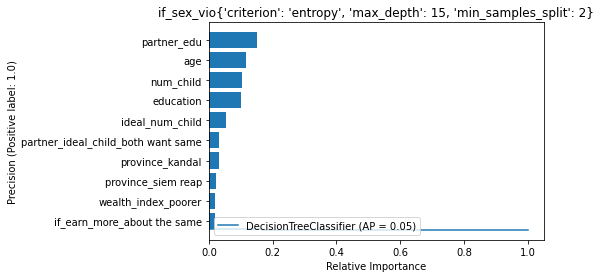

Params:  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}
{'f1': 0.125, 'accuracy': 0.9348837209302325, 'precision': 0.125, 'recall': 0.125, 'roc_auc': 0.5455917874396135}


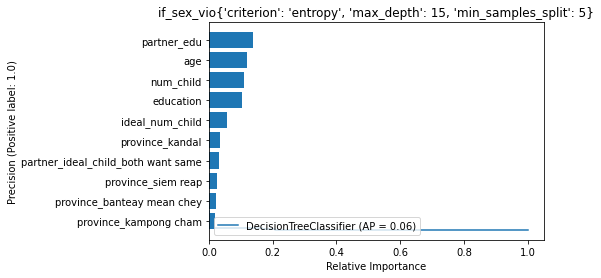


 
 Target:  if_vio 


Params:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.271523178807947, 'accuracy': 0.6589147286821705, 'precision': 0.2789115646258503, 'recall': 0.2645161290322581, 'roc_auc': 0.5240947992100066}


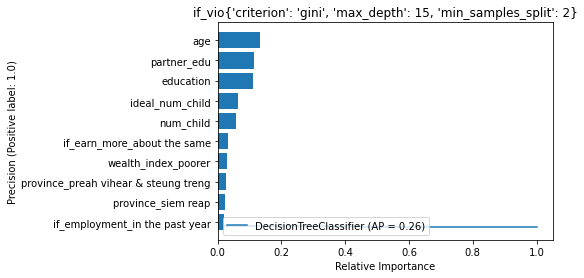

Params:  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}
{'f1': 0.291044776119403, 'accuracy': 0.7054263565891473, 'precision': 0.34513274336283184, 'recall': 0.25161290322580643, 'roc_auc': 0.5502962475312705}


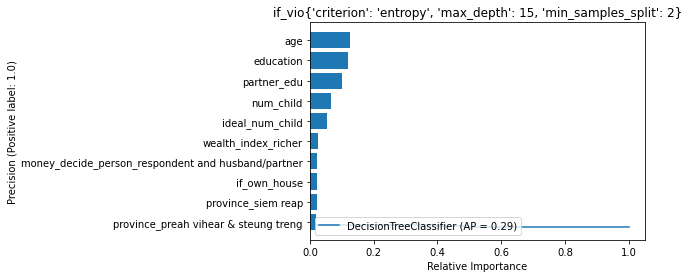

Params:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}
{'f1': 0.2332155477031802, 'accuracy': 0.6635658914728683, 'precision': 0.2578125, 'recall': 0.2129032258064516, 'roc_auc': 0.5095128373930218}


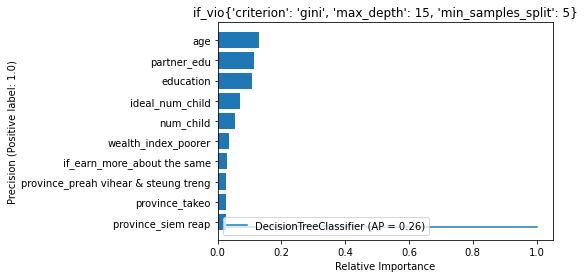

In [175]:
one_country_model_decision_tree(df, TARGET_LST, FEATURES, CATGORICAL_FEATURES)

In [176]:
def one_country_model_random_forest(df, TARGET_LST, FEATURES, CATGORICAL_FEATURES):
    '''
    Use decision tree to model data of one country
    '''
    for target_col in TARGET_LST:
        print("\n \n Target: ", target_col, "\n\n")
        features, target = preprocess_data(df, FEATURES, target_col, CATGORICAL_FEATURES)
        X_train, X_test, y_train, y_test = split_data(features, target)
        grid_result= train_random_forest(X_train, X_test, y_train, y_test)
        for params in grid_result['params'][:3]:
            print('Params: ', params)
            good_model = DecisionTreeClassifier(**params).fit(X_train, y_train)
            result_dict = evaluate_test(good_model, X_test, y_test)
            print(result_dict)
            plot_importances(good_model, X_train, n=10, title= target_col + str(params))

In [ ]:
one_country_model_random_forest(df, TARGET_LST, FEATURES, CATGORICAL_FEATURES)


 
 Target:  if_emo_vio 




[Reference: Decision Tree Ensembles- Bagging and Boosting](https://towardsdatascience.com/decision-tree-ensembles-bagging-and-boosting-266a8ba60fd9)